<a href="https://colab.research.google.com/github/fergaletto/Color-Balance-and-fusion-for-underwater-image-enhancement.-./blob/master/moving_object_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set the directories. 
DATA_PATH = '/content/gdrive/My Drive/Siamese/'
SIMILAR_PATH = DATA_PATH+ 'noise'
DIFFERENT_PATH = DATA_PATH+ 'moving'

# Prepare the dataset from the folders generated in matlab. 

In [34]:
import os
import json 
import shutil


json_file = DATA_PATH + 'labels.json' # the input json file
dest_folder = DATA_PATH + 'DATASET'

if not os.path.exists(dest_folder):
    os.mkdir(dest_folder)


def produce_pair(pairs_directory, label, json_file):
  # This function reads a folder which contains pair of patches (enfing in a.png
  # and split them into two separate lists + label.
  # Opening Jason file
  f = open(json_file)
  new_data = {'left_input': '017-001-004575a.png','right_input': '017-001-004575b.png','label': 'noise'}
  # return object as a dictionaty
  data = json.load(f)
  for root, dirs, files in os.walk(pairs_directory):
      for f in files:
        if (f[-5:]=='a.png'):
          new_data['left_input'] = f
          new_data['right_input'] = f[:-5]+'b.png'
          new_data['label'] = label
          #print(new_data)
          data.append(new_data)

        # move the images to the destination folder.
        original = pairs_directory  + '/' + f
        target = dest_folder + '/' + f
        shutil.copyfile(original, target)

  with open(json_file, "w") as outfile: 
      json.dump(data, outfile,  indent=4)




produce_pair(SIMILAR_PATH, 'noise', json_file);
produce_pair(DIFFERENT_PATH, 'moving', json_file);


# Create a pickle file with the dataset. 

In [65]:
## Data Creation
import cv2

data_dir = DATA_PATH + 'DATASET'
labels_file = DATA_PATH + 'labels.json'

classes = ['noise', 'moving']

def create_data(input_dir, labels):
    X_left = []
    X_right = []
    Y = []
    # Opening Jason file
    f = open(labels)
    data = json.load(f)
    for r in data: 
        X_left.append(cv2.imread(input_dir+'/'+r['left_input']))
        X_right.append(cv2.imread(input_dir+'/'+r['right_input']))
        Y.append(classes.index(r["label"]))
    
    X_left = np.asarray(X_left)
    X_right = np.asarray(X_right)
    Y = np.asarray(Y)
    return X_left,X_right, Y

  ## Create dataset
left_input,right_input, targets = create_data(data_dir, labels_file)

In [66]:
# Randomize the data

samples = left_input.shape[0];
indices = np.arange(samples)
np.random.shuffle(indices)

left_input = left_input[indices]
right_input = right_input[indices]
targets = targets[indices]

# split test and train data. 
X_left_train = left_input[:8*(samples//10)]
X_rigth_train = right_input[:8*(samples//10)] 
Y_train = targets[:8*(samples//10)] 

X_left_test = left_input[8*(samples//10):]
X_rigth_test = right_input[8*(samples//10):] 
Y_test = targets[8*(samples//10):] 

# Save pickle dataset
import pickle

with open(DATA_PATH + 'train.pickle', 'wb') as f:
    pickle.dump([X_left_train,X_rigth_train,Y_train,X_left_test,X_rigth_test,Y_test], f)


# START FROM A SAVED PICKLE FILE

In [57]:
import pickle
	
with open(DATA_PATH + 'train.pickle', 'rb') as f:
    X_left_train,X_rigth_train,Y_train,X_left_test,X_rigth_test,Y_test = pickle.load(f)



# Creating the structure of Siamese Network

break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are 

## Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be the same as the data size. 




In [67]:
left_input  = Input(X_left_train.shape[1:])
right_input = Input(X_rigth_train.shape[1:])

# Create a base Network in which both images will go through individually.

Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.


In [96]:
del base_network
base_network = Sequential([
               Conv2D(3,3,input_shape=X_left_train.shape[1:]), 
               Activation('relu'),
               Conv2D(3,3),   
               Activation('relu'),
               MaxPooling2D(),
                Conv2D(7,2),   #(N,35,35,5) -> (N,34,34,7)
               Activation('relu'),
               Flatten(), 
               Dense(8),
               Activation('sigmoid') #(N,18) 
                               ])

# Process the left and right inputs to the same Base Network(base_network)

In [97]:
processed_a = base_network(left_input)
processed_b = base_network(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
 use Lambda function for this.

In [98]:
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

In [99]:
L1_distance = L1_layer([processed_a , processed_b])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [100]:
prediction = Dense(1,activation='sigmoid')(L1_distance)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

# Define the Optimizer Adam and Compile the Siamese Model.

In [101]:
optimizer = Adam(0.001,decay = 1e-4)
siamese_net.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [102]:
siamese_net.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8)            1667        input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 8)            0           sequential_4[0][0]    

# Training!

In [103]:
siamese_net.fit([X_left_train,X_rigth_train], Y_train,
          batch_size=32,
          epochs=30,
          verbose=1,
          validation_data=([X_left_test,X_rigth_test],Y_test))

Epoch 1/30
71/71 [==============================] - 1s 15ms/step - loss: 0.4658 - accuracy: 0.9858 - val_loss: 0.3095 - val_accuracy: 1.0000
Epoch 2/30
71/71 [==============================] - 1s 13ms/step - loss: 0.2213 - accuracy: 1.0000 - val_loss: 0.1517 - val_accuracy: 1.0000
Epoch 3/30
71/71 [==============================] - 1s 13ms/step - loss: 0.1038 - accuracy: 1.0000 - val_loss: 0.0700 - val_accuracy: 1.0000
Epoch 4/30
71/71 [==============================] - 1s 13ms/step - loss: 0.0572 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 5/30
71/71 [==============================] - 1s 13ms/step - loss: 0.0432 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 1.0000
Epoch 6/30
71/71 [==============================] - 1s 13ms/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 1.0000
Epoch 7/30
71/71 [==============================] - 1s 13ms/step - loss: 0.0301 - accuracy: 1.0000 - val_loss: 0.0277 - val_accuracy: 1.0000
Epoch 8/30
71

# SAve the model

In [112]:
siamese_net.save(DATA_PATH+'model2.h5')

# evaluate the model

In [110]:
import keras
model = keras.models.load_model(DATA_PATH+'model.h5')
import numpy as np
from sklearn.metrics import classification_report
y_pred = model.predict([X_left_test,X_rigth_test])


print(classification_report(Y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       305

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564



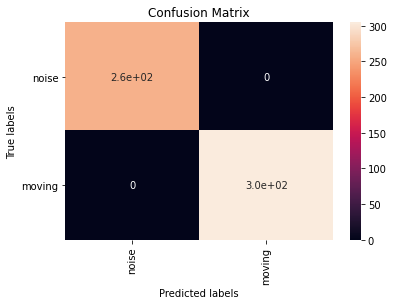

In [111]:


# COnfusion matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
sn.heatmap(confusion_matrix(Y_test, np.round(y_pred)), annot=True, ax = ax)
#plt.show()
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation = 90); ax.yaxis.set_ticklabels(classes, rotation = 0);

